In [66]:
import overpy
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from scipy.spatial import KDTree
import folium
import matplotlib.pyplot as plt

In [15]:
north, east = 35.660778, 139.606602
south, west = 35.658199, 139.602862

def rectangle_dimensions_km_geopy(sw_lat, sw_lon, ne_lat, ne_lon):
    height_km = geodesic((sw_lat, sw_lon), (ne_lat, sw_lon)).kilometers
    width_km = geodesic((sw_lat, sw_lon), (sw_lat, ne_lon)).kilometers
    return width_km, height_km

width, height = rectangle_dimensions_km_geopy(south, west, north, east)
print(f'{width:.2f}km x {height:.2f}km')

0.34km x 0.29km


In [16]:
cyclosm_tiles = 'https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png'
cyclosm_attribution = '&copy; <a href="https://www.cyclosm.org/">CyclOSM</a>'

m = folium.Map(location=[sum((north, south)) / 2, sum((east, west)) / 2], zoom_start=17, tiles=cyclosm_tiles, attr=cyclosm_attribution)

rectangle_bounds = [[min(north, south), min(east, west)], [max(north, south), max(east, west)]]

folium.Rectangle(
    bounds=rectangle_bounds,
    color='blue',
    fill=True,
    fill_color='red',
    fill_opacity=0.3,
    # popup='My Rectangle'
).add_to(m)
m

In [17]:
query = f"""
    [out:json][bbox:{south},{west},{north},{east}];
    (
      way[highway~"cycleway|path|footway|bridleway"][bicycle~"yes|designated"];
      way[highway~"living_street|pedestrian|residential|service|track|unclassified"][bicycle!="no"];
      way[highway~"primary|secondary|tertiary"][cycleway~"."][bicycle!="no"];
    );
    (._;>;);
    out body;
"""

api = overpy.Overpass()
result = api.query(query)

In [ ]:
edges = []
for way in result.ways:
    coords = [(float(node.lon), float(node.lat)) for node in way.nodes]
    if len(coords) < 2:
        continue
    
    geometry = LineString(coords)
    
    edges.append({
        "osmid": way.id,
        "highway": way.tags.get("highway"),
        "cycleway": way.tags.get("cycleway"),
        "bicycle": way.tags.get("bicycle"),
        "geometry": geometry
    })

gdf_edges = gpd.GeoDataFrame(edges, crs="EPSG:4326")
print('Number of edges:', len(gdf_edges))
gdf_edges.head()

Number of edges: 18


,osmid,highway,cycleway,bicycle,geometry
0,26354731,unclassified,None,None,"LINESTRING (139.6029 35.65853, 139.60284 35.65..."
1,30849729,service,None,None,"LINESTRING (139.60604 35.66279, 139.60603 35.6..."
2,32121767,unclassified,None,None,"LINESTRING (139.60301 35.65833, 139.60305 35.6..."
3,32121770,unclassified,None,None,"LINESTRING (139.60408 35.65854, 139.60408 35.6..."
4,39487890,residential,None,None,"LINESTRING (139.60856 35.65982, 139.60832 35.6..."


In [27]:
nodes = []
for node in result.nodes:
    nodes.append({
        "osmid": node.id,
        "x": float(node.lon),
        "y": float(node.lat),
        "geometry": Point(float(node.lon), float(node.lat))
    })

gdf_nodes = gpd.GeoDataFrame(nodes, crs="EPSG:4326")
print('Number of nodes:', len(gdf_nodes))
gdf_nodes.head()

Number of nodes: 111


,osmid,x,y,geometry
0,288748191,139.602840,35.658670,POINT (139.60284 35.65867)
1,343141770,139.606038,35.662793,POINT (139.60604 35.66279)
2,343141827,139.606030,35.662383,POINT (139.60603 35.66238)
3,343141829,139.606043,35.661711,POINT (139.60604 35.66171)
4,343142136,139.604149,35.663712,POINT (139.60415 35.66371)


In [67]:
# node_tuples = list(zip(gdf_nodes['x'].values.tolist(), gdf_nodes['y'].values.tolist()))
node_tuples_dict = {}
for _, row in gdf_nodes.iterrows():
    node_tuples_dict[(row['x'], row['y'])] = row['osmid']

node_tuples = list(node_tuples_dict.keys())
kdtree = KDTree(node_tuples)

In [ ]:
G = nx.Graph()

# for _, row in gdf_nodes.iterrows():
#     G.add_node(row["osmid"], x=row["x"], y=row["y"])
for (x, y), osmid in node_tuples_dict.items():
    G.add_node(osmid, x=x, y=y)

for _, row in gdf_edges.iterrows():
    if len(row['geometry'].coords) < 2:
        continue
    
    start_coord = (row['geometry'].coords[0][0], row['geometry'].coords[0][1])
    end_coord = (row['geometry'].coords[-1][0], row['geometry'].coords[-1][1])
    
    _, start_idx = kdtree.query(start_coord)
    _, end_idx = kdtree.query(end_coord)
    
    start_osmid = node_tuples_dict[node_tuples[start_idx]]
    end_osmid = node_tuples_dict[node_tuples[end_idx]]
    
    if start_osmid != end_osmid:
        G.add_edge(
            start_osmid,
            end_osmid,
            osmid=row['osmid'],
            highway=row.get('highway'),
            cycleway=row.get('cycleway'),
            geometry=row['geometry']
        )

In [72]:
print(f"Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")
sample_node = list(G.nodes)[16]
print(f"Edges for node {sample_node}: {list(G.edges(sample_node))}")

Nodes: 111, Edges: 18
Edges for node 473002974: []


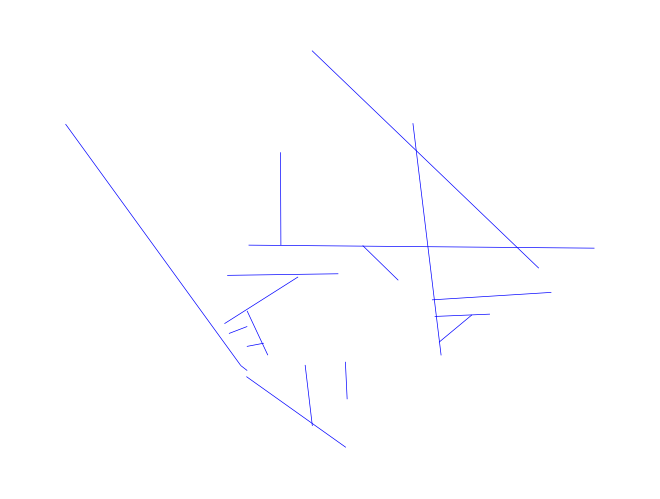

In [73]:
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}
nx.draw(G, pos, node_size=0, edge_color="blue", width=0.5)
plt.show()